# Implementation of a LSTM for Bias Correction

## Data Importing
See `Data Prep.ipynb` for the data preparation.

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import statsmodels as sm
from bias_correction import BiasCorrection
from scipy.stats import norm
%matplotlib widget

In [117]:
cleaned_data = pd.read_csv('Input Data/formatted_data_long.csv', index_col=0, parse_dates=[0])
cleaned_data.head()

,p_actual,clivi,clt,clwvi,evspsbl,evspsblpot,hfls,hfss,hurs,hus100,...,zg300,zg400,zg500,zg600,zg70,zg700,zg750,zg850,zg925,zmla
1951-01-01,0.0,0.000060,12.5,0.003315,0.000013,0.001513,33.58153,174.1547,29.20223,0.000005,...,9566.541,7495.741,5799.104,4357.022,18735.87,3101.249,2530.703,1478.512,756.1367,845.0737
1951-01-02,0.0,0.000079,25.0,0.000000,0.000014,0.000703,35.93560,176.1679,29.92788,0.000004,...,9605.465,7526.680,5815.817,4365.528,18709.88,3112.448,2545.754,1499.015,775.4705,991.3351
1951-01-03,0.0,0.000100,12.5,0.000000,0.000014,0.001134,34.66610,167.4318,24.82162,0.000004,...,9482.242,7437.816,5757.572,4329.994,18640.43,3088.378,2523.080,1473.241,744.7587,1111.6630
1951-01-04,0.0,0.001035,25.0,0.000000,0.000012,0.001391,29.73084,193.1622,37.44496,0.000005,...,9377.226,7344.356,5678.355,4262.776,18588.86,3029.216,2468.967,1434.658,722.2295,1075.0860
1951-01-05,0.1,0.000000,12.5,0.000000,0.000012,0.000798,29.65585,206.1623,48.43903,0.000005,...,9268.582,7265.858,5621.459,4224.815,18560.90,3009.613,2456.931,1435.457,728.8141,1071.2350


In [118]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23376 entries, 1951-01-01 to 2014-12-31
Columns: 147 entries, p_actual to zmla
dtypes: float64(147)
memory usage: 26.4 MB


In [119]:
chosen_variables = ["p_actual", "p_RCM", "va700", "va850", "ta700", "ta500", "hurs", "ua500"] # From Seo et al. 2019
df = cleaned_data[chosen_variables]

In [120]:
n = len(df)
raw_train_df = df[0:int(n*0.8)]
raw_val_df = df[int(n*0.8):]
raw_test_df = df[int(n*0.8):]

num_features = df.shape[1] - 1

In [121]:
def widen(col, index=0, n = num_features+1):
    """ Make single column in a matrix for transforming"""
    zeros = np.zeros((col.shape[0], n))
    zeros[:, index] = col
    return zeros

In [122]:
widen(np.array([1,2,3]))

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [2., 0., 0., 0., 0., 0., 0., 0.],
       [3., 0., 0., 0., 0., 0., 0., 0.]])

## Normalisation
Note this using training mean

In [123]:
train_mean = raw_train_df.mean()
train_std = raw_train_df.std()

cols = raw_train_df.columns

mean_scaler = StandardScaler()
train_df = mean_scaler.fit_transform(raw_train_df)
val_df = mean_scaler.transform(raw_val_df)
test_df = mean_scaler.transform(raw_test_df)


In [124]:
raw_test_df

,p_actual,p_RCM,va700,va850,ta700,ta500,hurs,ua500
2002-03-14,0.0,0.000000,0.915397,-3.018644,277.9129,264.7315,54.36404,7.054822
2002-03-15,0.0,0.000000,-1.850543,-3.397141,278.8822,265.8872,50.92908,6.584326
2002-03-16,0.0,0.000147,-12.547170,-8.319203,278.6227,263.4404,39.48558,11.134960
2002-03-17,0.0,0.000000,-7.036059,-0.952284,276.4075,260.1375,30.87824,15.738540
2002-03-18,0.0,0.000000,-7.896043,-2.481756,275.1973,257.2332,45.21654,14.970470
...,...,...,...,...,...,...,...,...
2014-12-27,0.0,0.139906,-4.847570,-5.105630,278.8670,262.7878,41.78381,-0.302331
2014-12-28,0.0,12.343614,-6.123385,-8.090288,280.4823,263.2766,55.00168,11.334220
2014-12-29,0.0,0.375558,-7.146146,-3.979928,280.8791,261.5784,39.39113,21.898130
2014-12-30,0.7,0.059802,-7.392488,-2.493279,279.6844,261.8648,42.24360,17.968610


In [125]:
raw_train_df

,p_actual,p_RCM,va700,va850,ta700,ta500,hurs,ua500
1951-01-01,0.0,0.000000,4.025313,3.450242,280.6955,265.0869,29.20223,21.553750
1951-01-02,0.0,0.000000,1.995692,0.220866,279.0921,267.2378,29.92788,17.559040
1951-01-03,0.0,0.000000,0.374894,-0.735619,277.8354,262.7172,24.82162,23.783430
1951-01-04,0.0,0.000000,3.664935,5.249837,275.8360,260.0374,37.44496,24.820310
1951-01-05,0.1,0.000000,6.587869,5.937426,271.8354,256.9410,48.43903,27.021040
...,...,...,...,...,...,...,...,...
2002-03-09,0.0,4.000101,-10.728910,-11.498490,278.7487,262.6813,47.36657,19.949010
2002-03-10,0.0,21.234260,-9.311050,-4.707406,277.3184,260.8432,53.24487,33.811790
2002-03-11,0.0,0.000000,-5.329623,-2.590898,277.6517,262.5791,53.15466,27.827800
2002-03-12,0.0,0.000000,-0.342054,0.131103,275.3979,261.7980,51.49392,20.958330


In [126]:
dry_threshold = 1 # Below 0.1 mm/day, consider dry
scale_x = np.zeros((1, num_features+1))
scale_x[0, 0] = dry_threshold
scaled_dry_threshold = mean_scaler.transform(scale_x)[0][0]
blank_scale = np.zeros((1, num_features+1))
scaled_zero = mean_scaler.transform(blank_scale)[0][0]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## LSTM

In [127]:
def create_sequences(data, seq_length):
    X_data = data[:, 1:]
    Y_data = data[:, 0]
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(X_data[i:i+seq_length])
        y.append(Y_data[i+seq_length])
    return np.array(X), np.array(y)

In [128]:
seq_length = 90 # Window length for the LSTM

In [129]:
X_train, y_train = create_sequences(train_df, seq_length)
X_test, y_test = create_sequences(test_df, seq_length)
X_val, y_val = create_sequences(val_df, seq_length)

### Loss Functions
Only `zero_percentage_loss` and `max_loss` were used in the final model.

In [130]:
def zero_percentage_loss(y_true, y_pred, threshold=scaled_dry_threshold):
    # Define a soft approximation for checking if values are near zero
    def soft_zero(x, threshold):
        # Use sigmoid to create a smooth approximation of a step function
        return tf.sigmoid(-100 * (x - threshold - 0.1))

    # Calculate the soft zero count for y_true and y_pred
    soft_zero_true = soft_zero(y_true, threshold)
    soft_zero_pred = soft_zero(y_pred, threshold)
    
    # Calculate the loss (MSE between the zero percentages)
    loss = tf.square(tf.reduce_mean(soft_zero_true - soft_zero_pred))
    
    return loss

In [131]:
def max_loss(y_true, y_pred):
    return tf.square(tf.reduce_max(y_true) - tf.reduce_max(y_pred))

In [132]:
def match_std(y_true, y_pred):
    return tf.square(tf.math.reduce_std(y_true) - tf.math.reduce_std(y_pred))

In [133]:
def means(y_true, y_pred):
    return tf.square(tf.reduce_mean(y_true) - tf.reduce_mean(y_pred))

In [134]:
def means_above_zero(y_true, y_pred):
    y_true_above_zero = tf.math.softplus(y_true-scaled_zero)
    y_pred_above_zero = tf.math.softplus(y_pred-scaled_zero)
    return tf.square(tf.reduce_mean(y_true_above_zero) - tf.reduce_mean(y_pred_above_zero))

In [135]:
def sum_loss(y_true, y_pred):
    return tf.square(tf.reduce_sum(y_true) - tf.reduce_sum(y_pred))

In [136]:
nulls = np.zeros(y_train.shape)
metrics = [zero_percentage_loss, max_loss]
baseline_loss = [loss(y_train, nulls).numpy() for loss in metrics] # Used to normalise for the output ranges of the loss functions
metric_weights = [1, 2] # Weights for the loss functions

In [137]:
@tf.keras.utils.register_keras_serializable()
def combo_loss(y_true, y_pred):
    return tf.reduce_sum([metric_weights[i] * loss(y_true, y_pred)/baseline_loss[i] for i, loss in enumerate(metrics)])

### Core LSTM Model

In [138]:
## From https://www.tensorflow.org/tutorials/structured_data/time_series
lstm_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(seq_length, num_features)),
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(128),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(),loss=combo_loss)

I've saved the model run used for the report in `trained_lstm.keras`, but uncommenting the second line will train the model from scratch

In [139]:
lstm_model = tf.keras.models.load_model('trained_lstm.keras')
# history = lstm_model.fit(X_train, y_train, epochs=300, batch_size=32, shuffle=False)

## Predictions on Train and Test Data

In [140]:
y_train_pred = lstm_model.predict(X_train)
y_pred = lstm_model.predict(X_test)

582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


### Classic Quantile Mapping for Comparison

Relies on https://pankajkarman.github.io/bias_correction/index.html#usage

In [141]:
train_start = len(train_df) - len(y_train) # Need to adjust for the sequence length - LSTM only starts predicting after an initial set of inputs
test_start = len(test_df) - len(y_test)

In [142]:
train_bc = BiasCorrection(raw_train_df['p_actual'], raw_train_df['p_RCM'], raw_train_df['p_RCM'])
test_bc = BiasCorrection(raw_train_df['p_actual'], raw_train_df['p_RCM'], raw_test_df['p_RCM'])

train_QM = train_bc.correct(method='basic_quantile')[train_start:]
test_QM = test_bc.correct(method='basic_quantile')[test_start:]

### Plotting Results

Handling the scaling and the transforming between numpy arrays and pandas dataframes.

In [143]:
def np_to_df_train(array):
    return pd.Series(data=array, index=raw_train_df.index[train_start:])

def np_to_df_test(array):
    return pd.Series(data=array, index=raw_test_df.index[test_start:])

In [144]:
def inv_transform(col):
    return mean_scaler.inverse_transform(widen(col))[:, 0]

In [145]:
y_test_denorm = np_to_df_test(inv_transform(y_test))
y_test_pred_denorm = np_to_df_test(np.maximum(inv_transform(y_pred.reshape(-1)), 0)) # Clip outputs to zero
y_train_denorm = np_to_df_train(inv_transform(y_train))
y_train_pred_denorm = np_to_df_train(np.maximum(inv_transform(y_train_pred.reshape(-1)), 0))
rcm_test_denorm = raw_test_df['p_RCM'][test_start:]
rcm_train_denorm = raw_train_df['p_RCM'][train_start:]


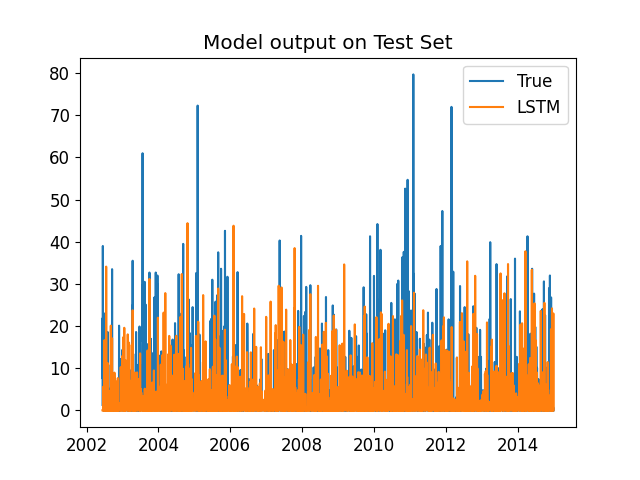

In [146]:
offset = len(test_df) - len(y_test)
x_axis = raw_test_df.index[offset:]
plt.figure()
plt.plot(x_axis, y_test_denorm, label='True')
plt.plot(x_axis, y_test_pred_denorm, label='LSTM')
# plt.plot(x_axis, test_QM, label='QM2')
plt.title("Model output on Test Set")
plt.legend()

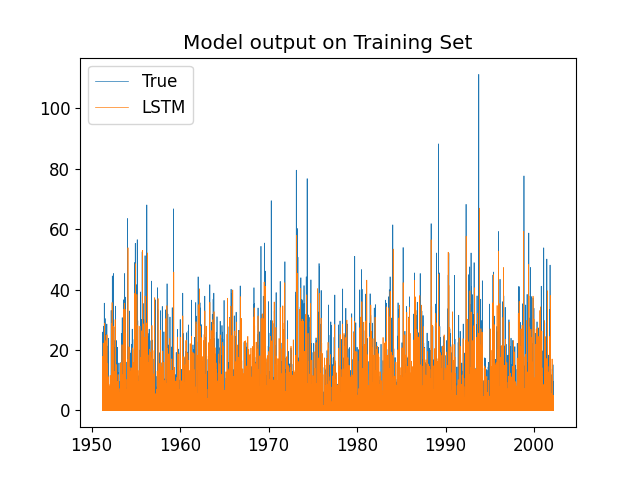

In [147]:
plt.figure()
plt.plot(y_train_denorm, label='True', linewidth=0.5)
plt.plot(y_train_pred_denorm, label='LSTM', linewidth=0.5)
# plt.plot(train_QM, label='QM', alpha=0.5)
plt.title("Model output on Training Set")
plt.legend()

(0.0, 80.0)

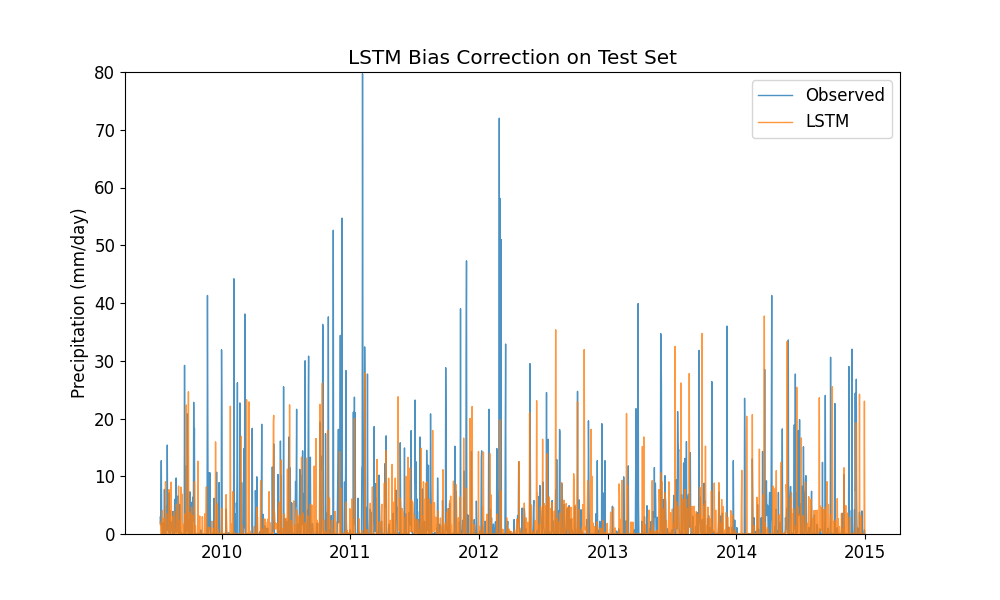

In [148]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10, 6))
plt.plot(y_test_denorm[-2000:], label='Observed', color='tab:blue', linewidth=1, alpha=0.8)
plt.plot(y_test_pred_denorm[-2000:], label='LSTM', color='tab:orange', linewidth=1, alpha=0.8)
# plt.plot(train_QM, label='QM', alpha=0.5)
plt.title("LSTM Bias Correction on Test Set")
plt.ylabel("Precipitation (mm/day)")
plt.legend()
plt.ylim((0,80))
# plt.savefig('Figures/report_test_output.png', dpi=500)

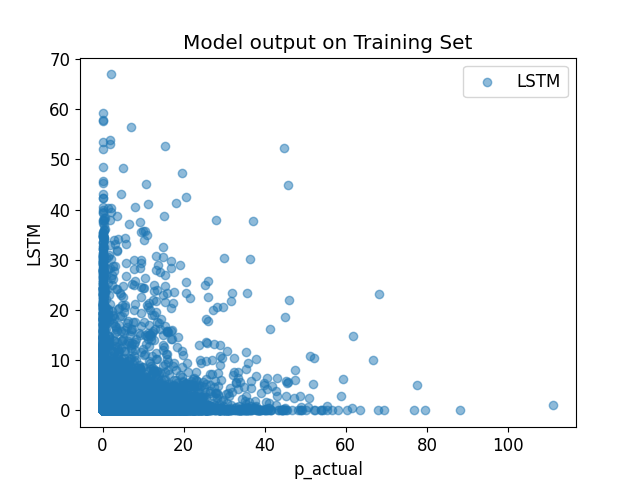

In [149]:
plt.figure()
plt.scatter(y_train_denorm, y_train_pred_denorm, label='LSTM', alpha=0.5)
plt.title("Model output on Training Set")
plt.xlabel("p_actual")
plt.ylabel("LSTM")
plt.legend()

Text(0.5, 0.98, 'Empiricial Cumulative Distribution Function (ECDF) of Precipitation on Test Set')

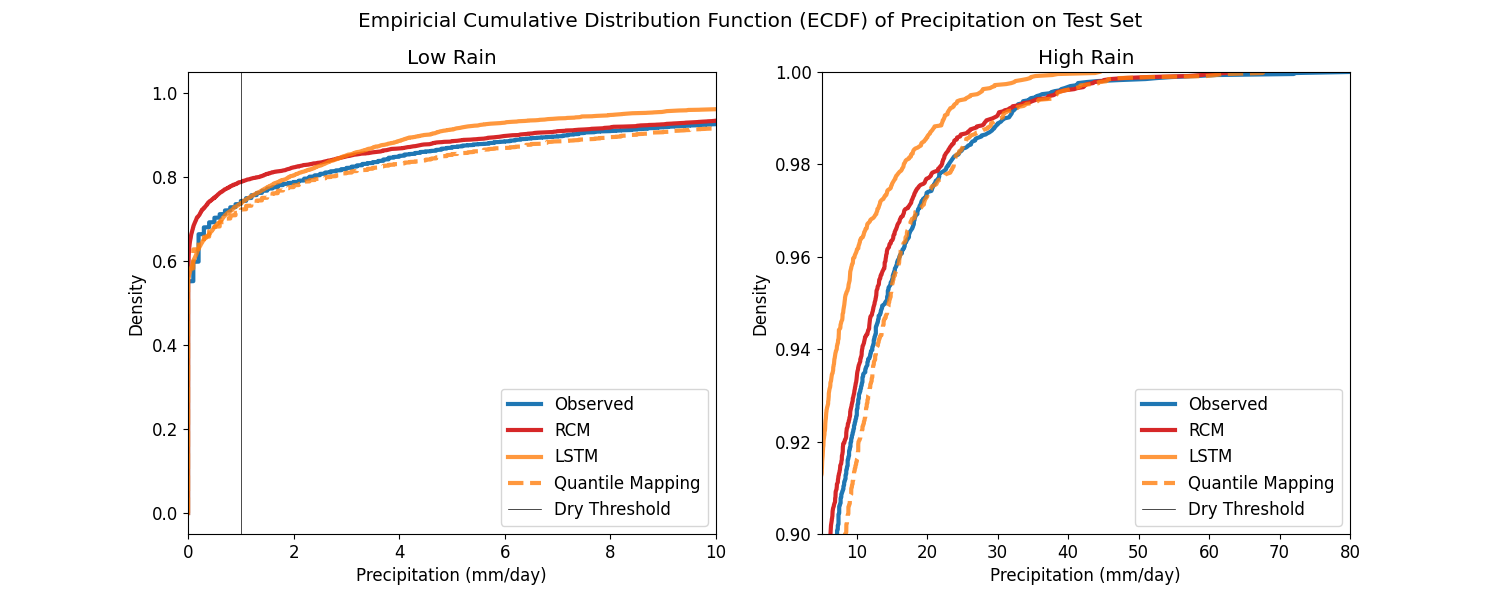

In [150]:
rcm_ecdf = sm.distributions.ECDF(rcm_test_denorm)
actual_ecdf = sm.distributions.ECDF(y_test_denorm)
lstm_ecdf = sm.distributions.ECDF(y_test_pred_denorm)
QM_ecdf = sm.distributions.ECDF(test_QM[offset:])

figs, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].set_title("Low Rain")
axs[0].plot(actual_ecdf.x, actual_ecdf.y, color='tab:blue', label='Observed', linewidth=3)
axs[0].plot(rcm_ecdf.x, rcm_ecdf.y, color='tab:red', label='RCM', linewidth=3)
axs[0].plot(lstm_ecdf.x, lstm_ecdf.y, color='tab:orange', label='LSTM', linewidth=3, alpha=0.8)
axs[0].plot(QM_ecdf.x, QM_ecdf.y, label='Quantile Mapping', color='tab:orange', linestyle='dashed', linewidth=3, alpha=0.8)
axs[0].axvline(dry_threshold, color='black', label='Dry Threshold', linewidth=0.5)
axs[0].set_xlabel("Precipitation (mm/day)")
axs[0].set_ylabel("Density")
axs[0].set_xlim(-0.01, 10)
axs[0].legend()

axs[1].set_title("High Rain")
axs[1].plot(actual_ecdf.x, actual_ecdf.y, color='tab:blue', label='Observed', linewidth=3)
axs[1].plot(rcm_ecdf.x, rcm_ecdf.y, color='tab:red', label='RCM', linewidth=3)
axs[1].plot(lstm_ecdf.x, lstm_ecdf.y, color='tab:orange', label='LSTM', linewidth=3, alpha=0.8)
axs[1].plot(QM_ecdf.x, QM_ecdf.y, label='Quantile Mapping', color='tab:orange', linestyle='dashed', linewidth=3, alpha=0.8)
axs[1].axvline(dry_threshold, color='black', label='Dry Threshold', linewidth=0.5)
axs[1].set_xlabel("Precipitation (mm/day)")
axs[1].set_ylabel("Density")
axs[1].legend(loc="lower right")
# Add vertical line at dry threshold
axs[1].set_xlim(5, 80)
axs[1].set_ylim(0.9,1)

figs.suptitle("Empiricial Cumulative Distribution Function (ECDF) of Precipitation on Test Set")
# figs.savefig('Figures/report_combined_ecdf.png', dpi=500)

In [151]:
#find 99th percentile of each
rcm_99 = np.percentile(rcm_test_denorm, 99)
lstm_99 = np.percentile(y_test_pred_denorm, 99)
QM_99 = np.percentile(test_QM[offset:], 99)
actual_99 = np.percentile(y_test_denorm, 99)
print(f"RCM 99th: {rcm_99}, LSTM 99th: {lstm_99}, QM 99th: {QM_99}, Actual 99th: {actual_99}")

RCM 99th: 29.315087567999896, LSTM 99th: 22.38364014956549, QM 99th: 30.471653387927137, Actual 99th: 31.089999999999783


### Setting every other variable to mean to isolate individual factors

In [152]:
var_names = {'p_RCM': 'Precipitation', 'va700': 'Northward Wind (700hPa)', 'va850': 'Northward Wind (850hPa)', 'ta700': 'Air Temperature (700hPa)', 'ta500': 'Air Temperature (500hPa)', 'hurs' : 'Relative Humidity', 'ua500': 'Eastward Wind at 500hPa'}

144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


Text(0.5, 0.98, 'Empiricial Cumulative Distribution Function (ECDF) from a Single Variable')

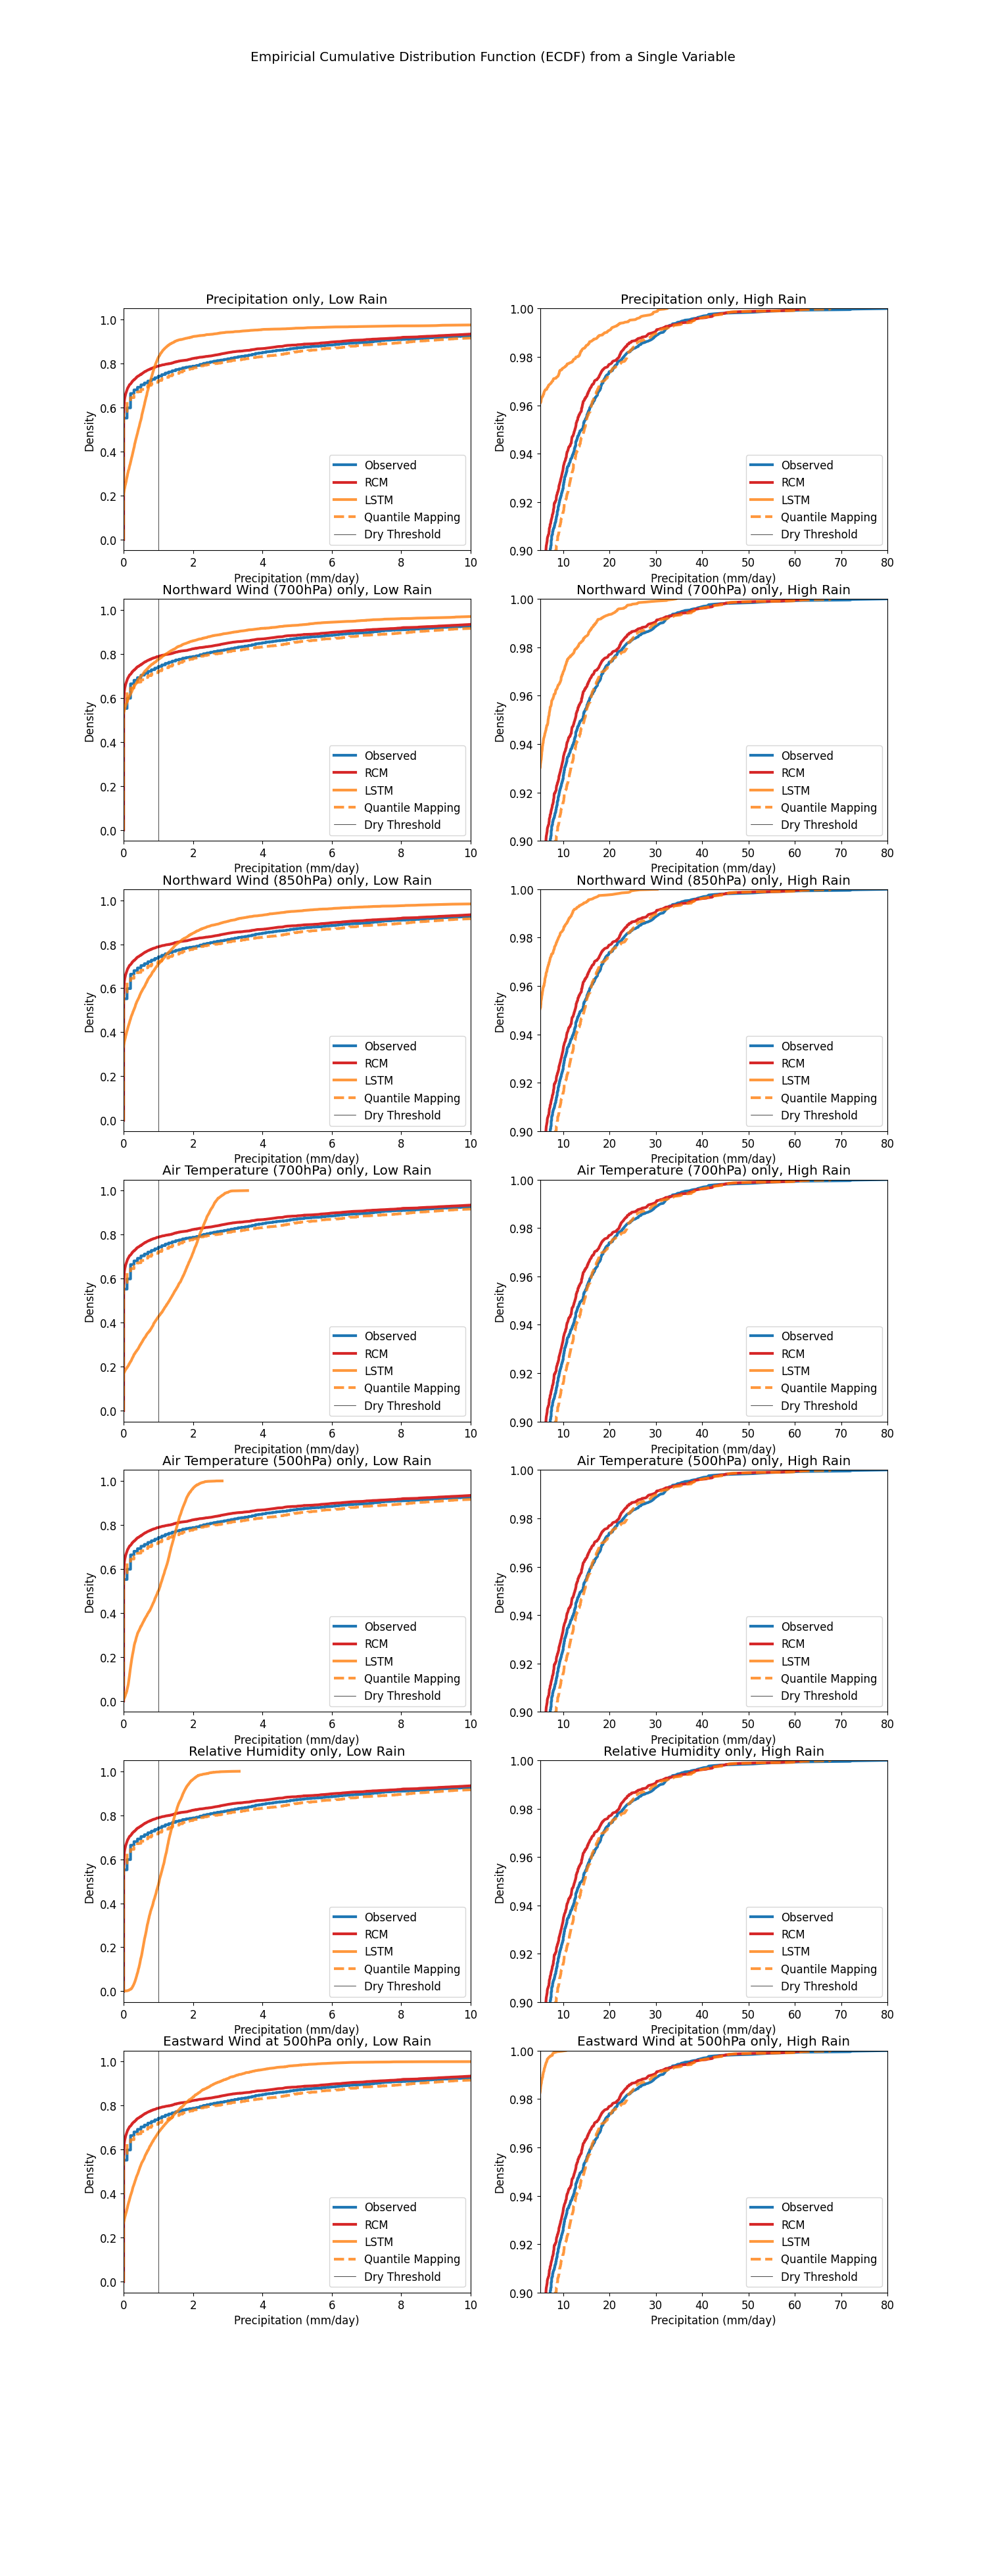

In [153]:
figs, axs = plt.subplots(len(chosen_variables)-1, 2, figsize=(15, 5.6*(len(chosen_variables)-1)))
for i, col_name in enumerate(chosen_variables[1:]):
    new_test = test_df.copy()
    # Set all other variables to zero
    new_test[:, 1:i+1] = 0
    new_test[:, i+2:] = 0
    new_X_test, new_y_test = create_sequences(new_test, seq_length)
    new_y_test_pred = lstm_model.predict(new_X_test)
    new_y_test_pred_denorm = np_to_df_test(inv_transform(new_y_test_pred.reshape(-1)))
    new_lstm_ecdf = sm.distributions.ECDF(new_y_test_pred_denorm)
    
    axs[i, 0].set_title(f"{var_names[col_name]} only, Low Rain")
    axs[i, 0].plot(actual_ecdf.x, actual_ecdf.y, color='tab:blue', label='Observed', linewidth=3)
    axs[i, 0].plot(rcm_ecdf.x, rcm_ecdf.y, color='tab:red', label='RCM', linewidth=3)
    axs[i, 0].plot(new_lstm_ecdf.x, new_lstm_ecdf.y, color='tab:orange', label='LSTM', linewidth=3, alpha=0.8)
    axs[i, 0].plot(QM_ecdf.x, QM_ecdf.y, label='Quantile Mapping', color='tab:orange', linestyle='dashed', linewidth=3, alpha=0.8)
    axs[i, 0].axvline(dry_threshold, color='black', label='Dry Threshold', linewidth=0.5)
    axs[i, 0].set_xlabel("Precipitation (mm/day)")
    axs[i, 0].set_ylabel("Density")
    axs[i, 0].set_xlim(-0.01, 10)
    axs[i, 0].legend()

    axs[i, 1].set_title(f"{var_names[col_name]} only, High Rain")
    axs[i, 1].plot(actual_ecdf.x, actual_ecdf.y, color='tab:blue', label='Observed', linewidth=3)
    axs[i, 1].plot(rcm_ecdf.x, rcm_ecdf.y, color='tab:red', label='RCM', linewidth=3)
    axs[i, 1].plot(new_lstm_ecdf.x, new_lstm_ecdf.y, color='tab:orange', label='LSTM', linewidth=3, alpha=0.8)
    axs[i, 1].plot(QM_ecdf.x, QM_ecdf.y, label='Quantile Mapping', color='tab:orange', linestyle='dashed', linewidth=3, alpha=0.8)
    axs[i, 1].axvline(dry_threshold, color='black', label='Dry Threshold', linewidth=0.5)
    axs[i, 1].set_xlabel("Precipitation (mm/day)")
    axs[i, 1].set_ylabel("Density")
    axs[i, 1].legend(loc="lower right")
    axs[i, 1].set_xlim(5, 80)
    axs[i, 1].set_ylim(0.9,1)
figs.suptitle("Empiricial Cumulative Distribution Function (ECDF) from a Single Variable")
# figs.savefig('Figures/report_single_variable_ecdf.png', dpi=500)
    

In [154]:
box_data = pd.DataFrame(columns=chosen_variables[1:])
for i, col_name in enumerate(chosen_variables[1:]):
    new_test = test_df.copy()
    # Set all other variables to zero
    new_test[:, 1:i+1] = 0
    new_test[:, i+2:] = 0
    new_X_test, new_y_test = create_sequences(new_test, seq_length)
    new_y_test_pred = lstm_model.predict(new_X_test)
    new_y_test_pred_denorm = np_to_df_test(np.maximum(inv_transform(new_y_test_pred.reshape(-1)),0))
    box_data[col_name] = new_y_test_pred_denorm

box_data = pd.concat([y_test_pred_denorm, box_data], axis=1)
box_data.rename(columns={0: 'All Variables'}, inplace=True)
box_data

144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


,All Variables,p_RCM,va700,va850,ta700,ta500,hurs,ua500
2002-06-12,0.000000,0.558235,0.000000,0.000000,0.057674,0.714218,0.979920,0.382473
2002-06-13,0.000000,0.309752,0.000000,0.000000,0.094961,0.967664,0.759873,0.000000
2002-06-14,0.105078,0.316932,0.795517,0.485655,0.054789,1.103048,0.480168,0.117725
2002-06-15,0.153311,0.379129,6.700524,0.676953,0.000000,0.949914,0.335388,0.000000
2002-06-16,0.000000,0.136951,8.010355,5.590451,0.000000,0.683438,0.855000,0.000000
...,...,...,...,...,...,...,...,...
2014-12-27,0.000000,0.000000,3.280943,0.386927,1.961788,1.457689,1.326859,2.256368
2014-12-28,0.000000,0.008781,0.000000,0.000000,2.293268,1.395592,1.623237,0.780406
2014-12-29,0.000000,0.000000,0.265799,0.000000,2.444845,1.501751,1.417902,0.665185
2014-12-30,23.002426,14.149699,0.596785,0.498647,2.571542,1.603149,1.650625,1.790372


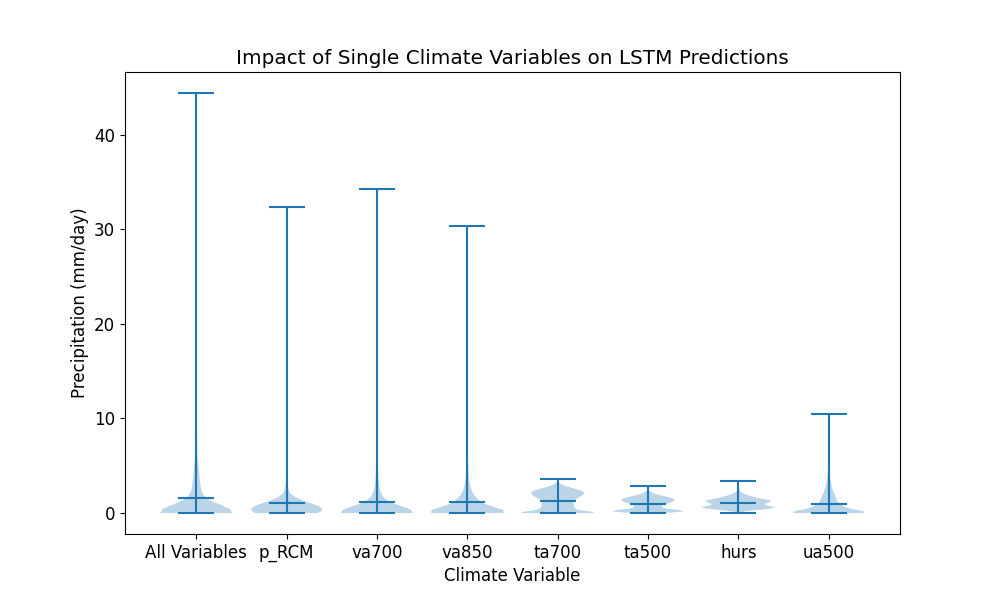

In [155]:
labels = box_data.columns.to_list()
plt.figure(figsize=(10, 6))
plt.violinplot(box_data.values, showmeans=True, widths=0.8)
plt.xticks(range(1, len(labels)+1), labels)
plt.ylabel("Precipitation (mm/day)")
plt.xlabel("Climate Variable")
plt.title("Impact of Single Climate Variables on LSTM Predictions")
# plt.ylim((-1,5))
# plt.savefig('Figures/report_single_variable_violin.png', dpi=500)
plt.show()

# Rainfall Metrics from Fu et al. (2021)

In [156]:
def annual_rainfall(model_df):
    """ Calculate annual rainfall from a dataframe"""
    return model_df.groupby(model_df.index.year).sum()

def rainfall_days(model_df, threshold=dry_threshold):
    """ Calculate the number of days with rainfall below the threshold"""
    return (model_df >= threshold).astype(int).groupby(model_df.index.year).sum()

def mean_length_wet_spell(model_df, threshold=dry_threshold):
    """ Calculate the mean length of wet spells, e.g. MeWS from Fu et al. (2021)"""
    current_wet_spell = 0
    in_wet_spell = False
    wet_spell_lengths = pd.Series()
    for (date, rainfall) in model_df.items():
        if rainfall >= threshold:
            in_wet_spell = True
            current_wet_spell += 1
        elif in_wet_spell: # Just left a wet spell
            wet_spell_lengths[date] = current_wet_spell # Add the length of the wet spell
            current_wet_spell = 0
            in_wet_spell = False
    return wet_spell_lengths.groupby(wet_spell_lengths.index.year).mean() # Average the wet spell lengths each year
            

def max_90_day_accumulated(model_df):
    """ Calculates the maximum of 90 day accumulated rainfal in a year, aka D90Max from Fu et al. (2021)"""
    return model_df.rolling(90).sum().groupby(model_df.index.year).max()

def p99_90_day_accumulated(model_df):
    """  Calculates the 99th percentile of 90 day accumulated rainfal in a year, aka D90P99 from Fu et al. (2021)"""
    return model_df.rolling(90).sum().groupby(model_df.index.year).apply(lambda x: x.quantile(0.99))

In [157]:
train_models = [('Actual', y_train_denorm), ('RCM', rcm_train_denorm), ('QM', train_QM), ('LSTM', y_train_pred_denorm), ]
test_models = [('Actual', y_test_denorm), ('RCM', rcm_test_denorm), ('QM', test_QM), ('LSTM', y_test_pred_denorm), ]
eval_metrics = [annual_rainfall, rainfall_days, mean_length_wet_spell, max_90_day_accumulated, p99_90_day_accumulated]

Text(0.5, 0.98, 'Evaluating Important Metrics for Streamflow on the Test Set')

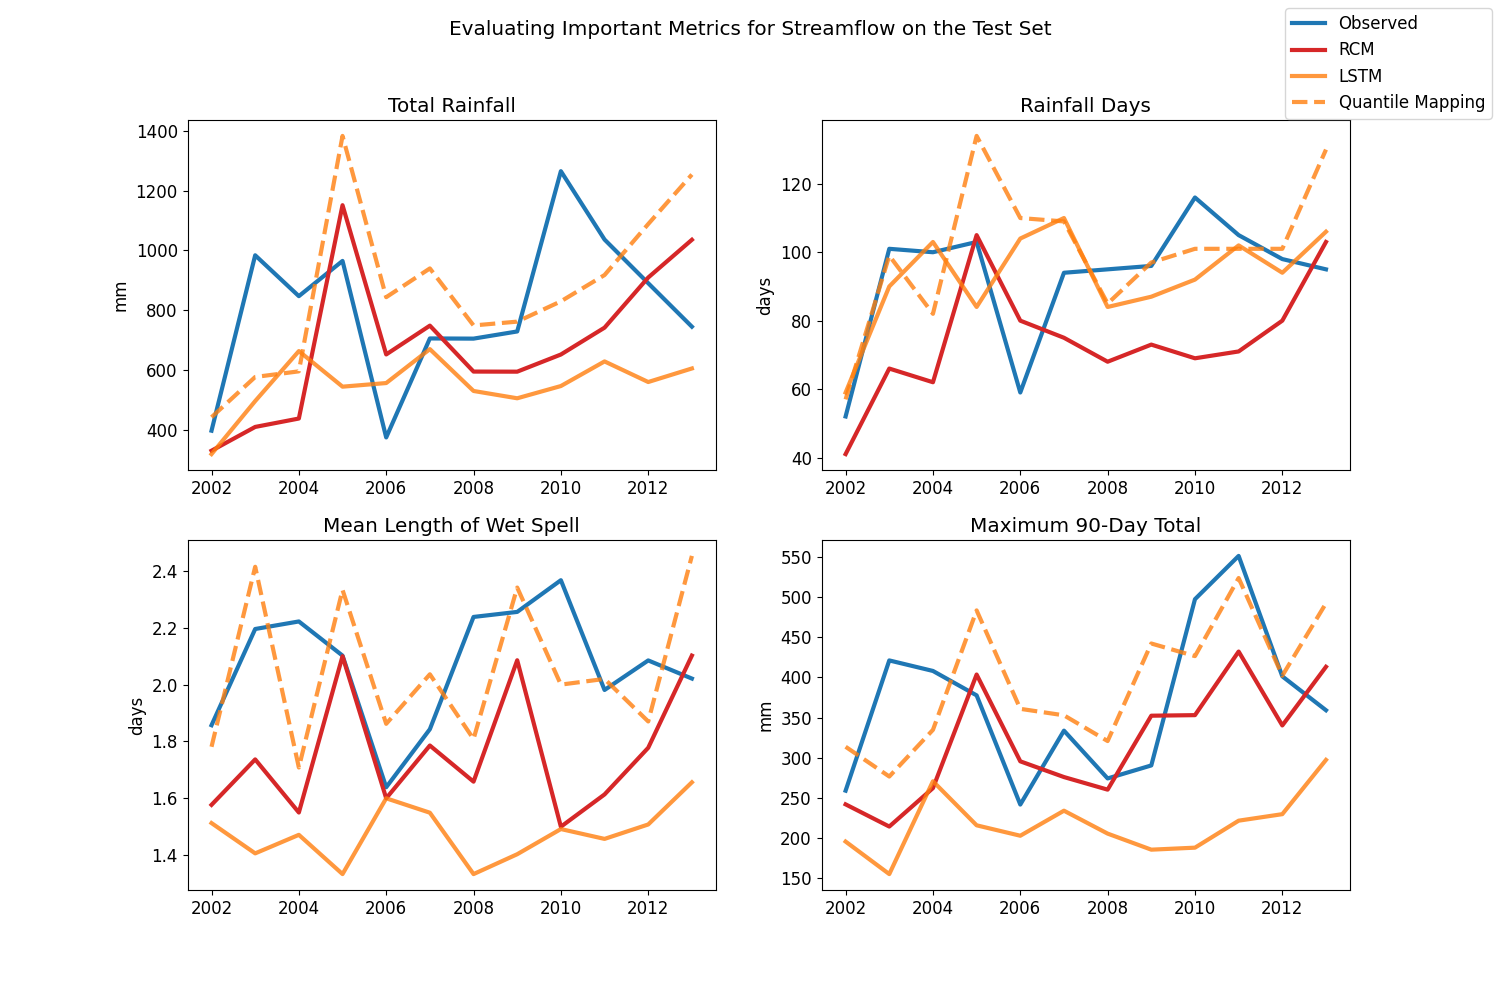

In [158]:
figs, axs = plt.subplots(2, 2, figsize=(15, 10))
names = {'annual_rainfall': 'Total Rainfall', 'rainfall_days': 'Rainfall Days', 'mean_length_wet_spell': 'Mean Length of Wet Spell', 'max_90_day_accumulated': 'Maximum 90-Day Total', 'p99_90_day_accumulated': '99th Percentile of 90 Day Accumulated Rainfall'}
y_labels = np.array([['mm', 'days'], ['days', 'mm']])
mse_df = pd.DataFrame(columns=names.values(), index=[name for (name, _) in test_models])
for metric, (i,j) in zip(eval_metrics, [(0,0), (0,1), (1,0), (1,1)]):
    results = pd.DataFrame()
    for (name, model) in test_models:
        results[name] = metric(model)
    results = results[:-1] # Drop last year as it is incomplete
    mse_df.loc[:, names[metric.__name__]] = results.apply(lambda x: np.sqrt(np.mean(np.square(x - results.Actual))))
    axs[i,j].plot(results.index, results.Actual, color='tab:blue', label='Observed', linewidth=3)
    axs[i,j].plot(results.index, results.RCM, color='tab:red', label='RCM', linewidth=3)
    axs[i,j].plot(results.index, results.LSTM, color='tab:orange', label='LSTM', linewidth=3, alpha=0.8)
    axs[i,j].plot(results.index, results.QM, label='Quantile Mapping', color='tab:orange', linestyle='dashed', linewidth=3, alpha=0.8)
    axs[i,j].set_title(names[metric.__name__])
    axs[i,j].set_ylabel(y_labels[i,j]) 
handles, labels = axs[0,0].get_legend_handles_labels()
figs.legend(handles, labels)
figs.suptitle("Evaluating Important Metrics for Streamflow on the Test Set")
# figs.savefig('Figures/report_fu_metrics.png', dpi=500)

In [159]:
mse_df

,Total Rainfall,Rainfall Days,Mean Length of Wet Spell,Maximum 90-Day Total,99th Percentile of 90 Day Accumulated Rainfall
Actual,0.0,0.0,0.0,0.0,NaN
RCM,315.522296,26.781523,0.418217,98.698304,NaN
QM,314.475508,21.825062,0.291422,92.957964,NaN
LSTM,339.438017,17.66588,0.647893,178.9813,NaN


In [160]:
train_df_names = pd.DataFrame(data=train_df, columns=raw_train_df.columns)
dropped_df = train_df_names.copy()
dropped_df['p_RCM'] = dropped_df['ta700'].mean() # set RCM data to mean
X_train_drop, y_train_drop = create_sequences(dropped_df.to_numpy(), seq_length)

## Figure to Demonstrate Bias Correction

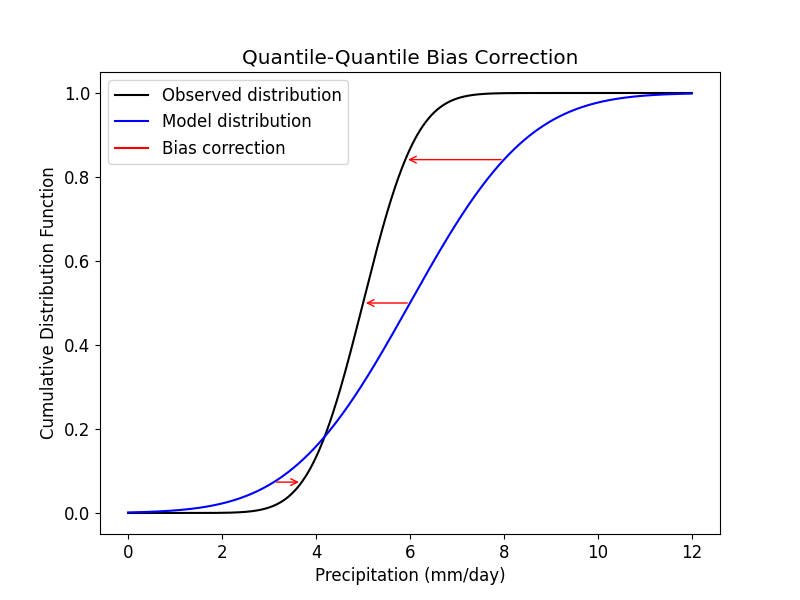

In [161]:
x = np.linspace(0,12, 1000)
observed_dist = norm(loc=5, scale=0.9)
model_dist = norm(loc=6, scale=2)

# Get the CDF values for both distributions
observed_cdf = observed_dist.cdf(x)
model_cdf = model_dist.cdf(x)

# Create the plot
plt.figure(figsize=(8, 6))

# Plot observed CDF (black line)
plt.plot(x, observed_cdf, label='Observed distribution', color='black')

# Plot model CDF (blue line)
plt.plot(x, model_cdf, label='Model distribution', color='blue')

# Add red correction arrows (difference between observed and model CDFs)
correction_points = [3.1, 6, 8]  # Example points on x-axis (temperature)
for cp in correction_points:
    # Find the y-values (CDF) at each correction point for both distributions
    model_value = model_dist.cdf(cp)
    observed_x = observed_dist.ppf(model_value)
    plt.annotate(text='', xy=(observed_x, model_value), xytext=(cp, model_value), arrowprops=dict(arrowstyle='->', color='red'))
    

plt.plot([], [], color='red', label='Bias correction', linestyle='-')

# Labels and title
plt.xlabel('Precipitation (mm/day)')
plt.ylabel('Cumulative Distribution Function')
plt.legend()
plt.title("Quantile-Quantile Bias Correction")
# plt.savefig('Figures/report_qq_bias_correction.png', dpi=500)
plt.show()